# Analyzing flights from Toronto to Harare

### Data sources
* yyz_to_hre_flights.xlsx manually generated from PDF file of flights from Expedia (18 December 2021 - 1 January 2021)

In [1]:
#Importing the libraries
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import dataframe_image

In [2]:
#Creating a dataframe of the excel file
flights = pd.read_excel('yyz_to_hre_flights.xlsx')

#First two rows of the dataframe
flights.head(2)

,ID,Route,Departure,Arrival,Flight Duration,Layover duration 1,Layover duration 2,Layover duration 3,Layover duration 4,Number of stops,Price,Cabin Type,Airline,Stop 1,Stop 2,Stop 3,Stop 4,Departure hour
0,1,Toronto (YYZ) - Harare (HRE),11:20:00,12:35:00,18h 15m,1h 45m,NaN,NaN,NaN,1,2626,Economy,Ethiopian Airlines,Addis Ababa (ADD),NaN,NaN,NaN,11
1,2,Toronto (YYZ) - Harare (HRE),22:05:00,11:05:00,54h 0m,11h,23h 15m,NaN,NaN,2,2627,Economy,British Airways,London (LHR),Johannesburg (JNB),NaN,NaN,22


## Data cleaning

In [3]:
#Renaming columns to snakecase
flights.columns = flights.columns.str.lower().str.replace(' ', '_')

In [4]:
#Removing whitespace from the route column
flights['route'] =  flights['route'].str.strip()

In [5]:
#List of columns with the names of the stops
stop_columns = ['stop_1', 'stop_2', 'stop_3', 'stop_4']

#Removing whitespace from the stop columns
#and filling null values with '?'
for stop_column in stop_columns:
    flights[stop_column] =  flights[stop_column].str.strip()

#List of columns with the time data
time_columns = ['flight_duration', 'layover_duration_1', 
                'layover_duration_2', 'layover_duration_3',
                'layover_duration_4']
    
#Removing white space from the time columns
for time_column in time_columns:
    flights[time_column] =  flights[time_column].str.strip()

In [6]:
#Creating a dictionary with the long-form 
#of the airport and the three-letter code
airport_dict = {}
for stop_column in stop_columns:
    airports = flights[stop_column].unique().tolist()
    
    
    for stop in airports:
        if type(stop) is str:
            airport = stop.split('(')
            city_name = airport[0].strip()
            airport_code = airport[1]
            airport_code = airport_code[0:3]
            if city_name in airport_dict:
                pass
            else:
                airport_dict[airport_code] = city_name

In [7]:
#Converting the airport code dictionary to a datafram
#and then creating an image of the dataframe
airport_codes = pd.DataFrame.from_dict(airport_dict, orient = 'index', columns = ['City'])
airport_codes.reset_index(inplace = True)
airport_codes.rename(columns = {'index': 'Airport'}, inplace = True)
airport_codes.sort_values('Airport', inplace = True)
dataframe_image.export(airport_codes, 'airport_codes.png')

In [8]:
#Removing the city name and only including the 
#airport three-letter code
for stop_column in stop_columns:
    flights[stop_column] = flights[stop_column].str.split('(', n = 1).str[1]
    flights[stop_column] = flights[stop_column].str.replace(')', '')
    flights[stop_column] = flights[stop_column].astype('str')

In [9]:
#Creates a column with the flight pattern
flights['flight_pattern'] = ['-'.join(row) for row in flights[stop_columns].values]

def CleanPattern(flight_pattern):
    """This function removed the '-nan' 
    from the flight pattern"""
    
    if 'nan' in flight_pattern:
        flight_pattern = flight_pattern.replace('-nan', '')
        return flight_pattern
    else:
        return flight_pattern
    
#Cleaning the flight pattern
flights['flight_pattern'] = flights['flight_pattern'].apply(CleanPattern)

In [10]:
def ConvertTime(time_string):
    
    """This function converts the time from strings of 
    hours and minutes to minutes as an interger"""
    if type(time_string) is str:
        time_list = time_string.split()
        if len(time_list) > 1:
            hours = int(time_list[0][:-1])
            minutes = int(time_list[1][:-1])
        else:
            single_time = time_list[0]
            if 'h' in single_time:
                hours = int(single_time[:-1])
                minutes = 0
            elif 'm' in single_time:
                minutes = int(single_time[:-1])
                hours = 0
            else:
                minutes = 0
                hours = 0

        total_minutes = (hours * 60) + minutes
        return total_minutes
    
    else:
        return 0

In [11]:
#Converting all of the time columns to minutes
for time_column in time_columns:
    flights[time_column] = flights[time_column].apply(ConvertTime)

#Adds the layover time in miuntes
flights['total_layover_time'] = flights[time_columns[1:]].sum(axis = 'columns')

#Calculates the actual flight time
flights['flight_time'] = flights['flight_duration'] - flights['total_layover_time']

In [12]:
def GetTime(hour):
    """This function gets the 24-hour integer
    and return the time category"""
    if hour < 12:
        return 'Morning'
    elif hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

In [13]:
#A column with the time category of the flight
flights['time_text'] = flights['departure_hour'].apply(GetTime)

In [14]:
#Sorting the data by departure time, flight pattern
#and cabin_type
flights.sort_values(['departure', 'flight_pattern', 'cabin_type'], inplace = True)

In [15]:
#Subset of the data with economy flights
economy_flights = flights.loc[flights['cabin_type'] == 'Economy', :].copy()

In [16]:
#Some flights in the dataset are of the same flight pattern,
#and flight duration and only differ in price and cabin type
#so this creates a subset without duplicates for duplicates
duplicate_columns = ['flight_pattern', 'flight_duration', 
                     'departure', 'total_layover_time', 'layover_duration_1']

duplicate_free = flights.drop_duplicates(subset = duplicate_columns, keep = 'first')

## Exploratory data analysis

In [17]:
sns.set_style('ticks')

#### Minimum price of flights

In [18]:
flights['price'].min()

2626

#### Maximum price of economy flights

In [19]:
economy_flights['price'].max()

3296

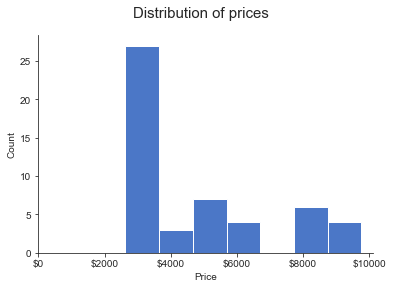

In [20]:
#Creating the histogram of the flight prices
fig, ax = plt.subplots()
sns.histplot(x = 'price', data = flights, ax = ax, color = '#0e49b5')

#Removing the top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#Formatting of the chart
ax.xaxis.set_major_formatter('${x:1.0f}')
ax.set_xlim(0,)
ax.set_xlabel('Price')

fig.suptitle('Distribution of prices', fontsize = 15)
plt.savefig('price_distribution.png', dpi = 300)
plt.show()

#### What is the average duration of the flights, including layovers?

In [21]:
pd.to_timedelta(duplicate_free['flight_duration'].mean(), 'minutes')

Timedelta('1 days 17:08:56.170212780')

#### What is the distribution of flight duration, including layovers?

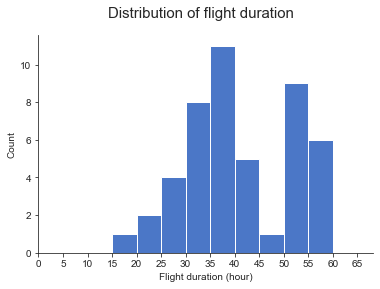

In [22]:
#Duration bins in minutes
duration_bins = [i for i in range(0, 4200, 300)]

#Creating the histogram of the flight duration
fig, ax = plt.subplots()
sns.histplot(x = 'flight_duration', data = duplicate_free, 
             bins = duration_bins, ax = ax, color = '#0e49b5')



#Using hour labels for xticks because hours
#will be easier to understand than large
#minutes
ax.set_xticks(duration_bins)
xtick_labels = [i for i in range(0, 70, 5)]
ax.set_xticklabels(xtick_labels)

#Removing the top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#Formatting the chart
ax.set_xlim(0,)
ax.set_xlabel('Flight duration (hour)')


fig.suptitle('Distribution of flight duration', fontsize = 15)
plt.savefig('flight_duration.png', dpi = 300)
plt.show()

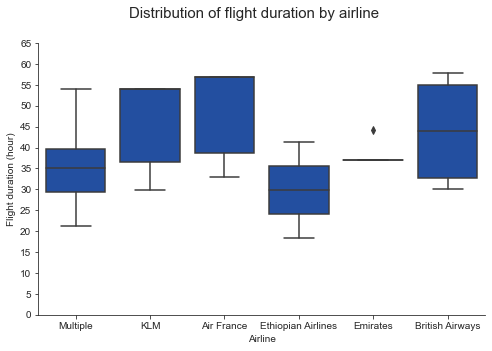

In [23]:
#Creating a boxplot
fig, ax = plt.subplots(figsize =  (8,5))
sns.boxplot(x = 'airline', y = 'flight_duration', data = 
            duplicate_free, ax = ax, color = '#0e49b5')

#Removing the top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#Axis labels
ax.set_ylabel('Flight duration (hour)')
ax.set_xlabel('Airline')


#Using hour labels for yticks because hours
#will be easier to understand than large
#minutes
ax.set_yticks(duration_bins)
ytick_labels = [i for i in range(0, 70, 5)]
ax.set_yticklabels(ytick_labels)
ax.set_ylim(0,)

fig.suptitle('Distribution of flight duration by airline', fontsize = 15)
plt.savefig('airline_flight_duration.png', dpi = 300)
plt.show()

#### Shortest flight duration

In [24]:
flights.nsmallest(1, 'flight_duration')['flight_pattern']

0    ADD
Name: flight_pattern, dtype: object

#### Longest flight duration

In [25]:
flights.nlargest(1, 'flight_duration')['flight_pattern']

2    LHR-JNB
Name: flight_pattern, dtype: object

In [26]:
pd.to_timedelta(flights.nlargest(1, 'flight_duration')['total_layover_time'], 'minutes')

2   1 days 14:00:00
Name: total_layover_time, dtype: timedelta64[ns]

#### What is the distribution of flight time?

In [27]:
pd.to_timedelta(duplicate_free['flight_time'].mean(), 'minutes')

Timedelta('0 days 20:06:49.787234040')

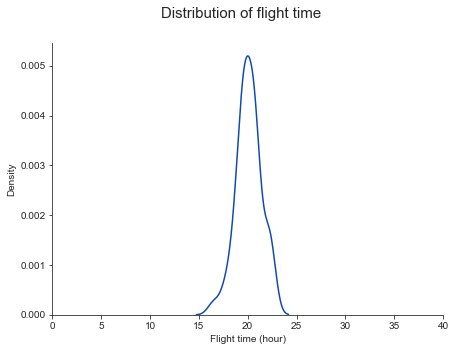

In [28]:
#Creating the histogram of the flight time
fig, ax = plt.subplots(figsize = (7,5))
#sns.kdeplot(x = 'flight_time', data = duplicate_free, bins = flight_time_bins, ax = ax)
sns.kdeplot(x = 'flight_time', data = duplicate_free, ax = ax , color = '#0e49b5')

ax.set_xlim(0,)
ax.set_xlabel('Flight time (hour)')

#Ticks in intervals of 300 minutes (5 hours)
flight_time_ticks = [i for i in range(0, 2700, 300)]
ax.set_xticks(flight_time_ticks)

#Hour labels for xticks
xtick_labels = [i for i in range(0,45, 5)]
ax.set_xticklabels(xtick_labels)

#Removing the top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.suptitle('Distribution of flight time', fontsize = 15)
plt.savefig('flight_time.png', dpi = 300)
plt.show()

#### Shortest flight time

In [29]:
duplicate_free.nsmallest(1, 'flight_time')['flight_pattern']

0    ADD
Name: flight_pattern, dtype: object

In [30]:
pd.to_timedelta(duplicate_free.nsmallest(1, 'flight_time')['flight_time'], 'minutes')

0   0 days 16:30:00
Name: flight_time, dtype: timedelta64[ns]

#### Longest flight time

In [31]:
duplicate_free.nlargest(1, 'flight_time')[['airline', 'flight_pattern']]

,airline,flight_pattern
42,Emirates,LGW-DXB-LUN


In [32]:
pd.to_timedelta(duplicate_free.nlargest(1, 'flight_time')['flight_time'], 'minutes')

42   0 days 22:25:00
Name: flight_time, dtype: timedelta64[ns]

#### What is the average layover time?

In [33]:
pd.to_timedelta(duplicate_free['total_layover_time'].mean(), 'minutes')

Timedelta('0 days 21:02:06.382978740')

#### Minimum layover time

In [34]:
duplicate_free.nsmallest(1, 'total_layover_time')['flight_pattern']

0    ADD
Name: flight_pattern, dtype: object

In [35]:
pd.to_timedelta(duplicate_free.nsmallest(1, 'total_layover_time')['total_layover_time'], 'minutes')

0   0 days 01:45:00
Name: total_layover_time, dtype: timedelta64[ns]

#### Maximum layover time

In [36]:
duplicate_free.nlargest(1, 'total_layover_time')['flight_pattern']

2    LHR-JNB
Name: flight_pattern, dtype: object

In [37]:
pd.to_timedelta(duplicate_free.nlargest(1, 'total_layover_time')['total_layover_time'], 'minutes')

2   1 days 14:00:00
Name: total_layover_time, dtype: timedelta64[ns]

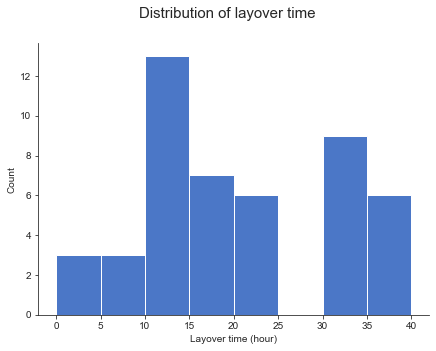

In [38]:
#Bins in intervals of 300 minutes (5 hours)
bins = [i for i in range(0, 2700, 300)]

#Creating the histogram of the layover time
fig, ax = plt.subplots(figsize = (7,5))
sns.histplot(x = 'total_layover_time', data = duplicate_free, 
             bins = bins, ax = ax, color = '#0e49b5')

#Removing the top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#Hour tick labels
xticks = [i for i in range(0,45, 5)]
ax.set_xticks(bins)
ax.set_xticklabels(xticks)

ax.set_ylim(0,)
ax.set_xlabel('Layover time (hour)')

fig.suptitle('Distribution of layover time', fontsize = 15)
plt.savefig('total_layover_time.png', dpi = 300)
plt.show()

#### What are the different number of airlines that offer these routes?

In [39]:
airlines_list = flights['airline'].unique().tolist()
airlines_list

['Multiple',
 'KLM',
 'Air France',
 'Ethiopian Airlines',
 'Emirates',
 'British Airways']

#### How many economy flights of each route?

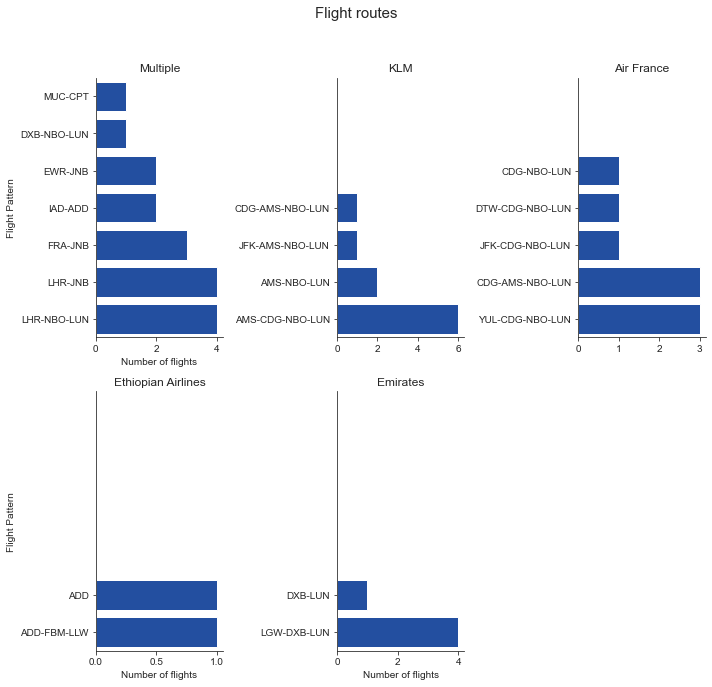

In [40]:
#Grouping the flights by flight pattern and airline
flight_patterns = duplicate_free.groupby(['flight_pattern', 'airline'], as_index = False)['id'].count()
flight_patterns.rename(columns = {'id': 'num_flights'}, inplace = True)
flight_patterns.sort_values('num_flights', inplace = True, ascending = False)



#Creating a chart with bar charts of each
#route and the number of flights
max_bars = 7
fig = plt.figure(figsize = (10, 10))
for idx in range(0,5):
    ax = fig.add_subplot(2, 3, idx + 1)
    temp_df = flight_patterns.loc[flight_patterns['airline'] == airlines_list[idx]]
    sns.barplot(x = 'num_flights', y = 'flight_pattern', data = temp_df, color = '#0e49b5')
    ax.set_title(airlines_list[idx])
    ax.set_ylim(-0.5, max_bars-0.5)

    #Removing the top and right borders
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    if idx == 0 or idx == 3:
        ax.set_ylabel('Flight Pattern')
        ax.set_xlabel('Number of flights')
    else:
        ax.set_ylabel('')
        ax.set_xlabel('')
        

ax.set_xlabel('Number of flights')
ax.set_ylabel('')
fig.suptitle('Flight routes', fontsize = 15)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('routes.png', dpi = 300)
plt.show()

#### What time do the different flights depart?

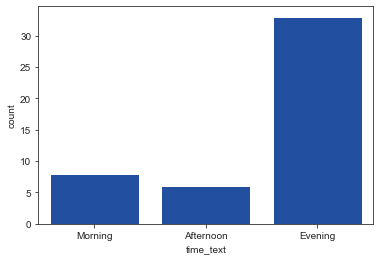

In [41]:
sns.countplot(x = 'time_text', data = duplicate_free, color = '#0e49b5')
plt.show()

### Statistical analysis

In [42]:
def NormalTestResults(column):
    """Returns the results of of normal distribution test"""
    statistic, pvalue = stats.normaltest(column)
    alpha = 0.05
    if pvalue < alpha:
        return 'The null hypothesis can be rejected'
    else:
         return 'The null hypothesis cannot be rejected'

#### Is the flight duration normally distributed??

In [43]:
NormalTestResults(duplicate_free['flight_duration'])

'The null hypothesis can be rejected'

#### Is the layover time normally distributed?

In [44]:
NormalTestResults(duplicate_free['total_layover_time'])

'The null hypothesis can be rejected'

#### Are the prices normally distributed?

In [45]:
NormalTestResults(economy_flights['price'])

'The null hypothesis cannot be rejected'

The null hypothesis cannot be rejected, so economy flights' prices do follow a normal distribution.

#### What is the correlation of 'flight duration,' 'total layover time,' 'flight_time' and 'price?

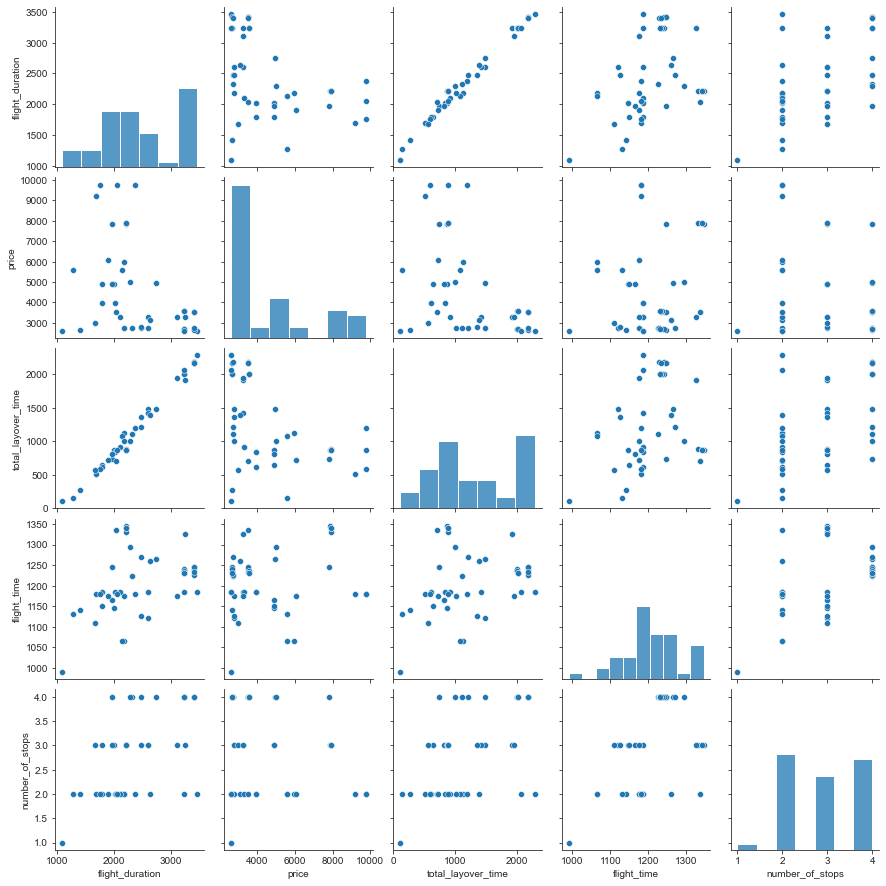

In [46]:
distribution_columns = ['flight_duration', 'price', 
                        'total_layover_time', 'airline', 
                        'flight_time', 'number_of_stops']
sns.pairplot(data = duplicate_free[distribution_columns])
plt.show()

There seems to be no correlation between most variables, except a positive correlation between the flight duration and the total layover time. 

#### Correlation matrix

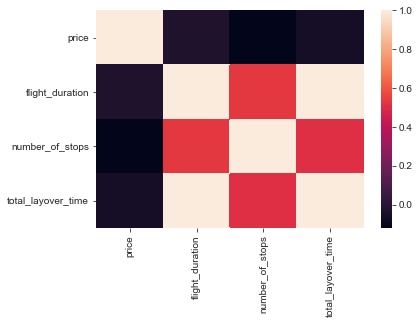

In [47]:
correl_columns = ['price', 'flight_duration', 'number_of_stops',  'total_layover_time']
correl_matrix = economy_flights[correl_columns].corr()
sns.heatmap(correl_matrix)
plt.show()

There is a strong positive correlation between the flight duration and the total layover time.

In [48]:
correl_matrix.loc['flight_duration']

price                -0.032468
flight_duration       1.000000
number_of_stops       0.535876
total_layover_time    0.996776
Name: flight_duration, dtype: float64

### Hypothesis testing
Based on a rough estimate of the cost of flights I have taken in the past, I tested the hypothesis that the average price of an economy flight to Zimbabwe is **\$3000**.


**Hypothesis**
* HA: µ = \$3000
* HA: µ ≠ \$3000

In [49]:
population_mean = 3000
statistic, pvalue = stats.ttest_1samp(a = economy_flights['price'], popmean = population_mean)
alpha = 0.05
if pvalue < alpha:
    print('The null hypothesis can be rejected')
else:
    print('The null hypothesis cannot be rejected')

The null hypothesis can be rejected


The null hypothesis can be rejected, so the average price of a flight of an economy flight may not be **\$3000**.

I then decided to test the hypothesis that the average price of an economy flight is **\$2900**.

**Hypothesis**
* HA: µ = \$2900
* HA: µ ≠ \$2900

In [50]:
population_mean_2 = 2900
statistic, pvalue_2 = stats.ttest_1samp(a = economy_flights['price'], popmean = population_mean_2)
alpha = 0.05
if pvalue_2 < alpha:
    print('The null hypothesis can be rejected')
else:
    print('The null hypothesis cannot be rejected')

The null hypothesis cannot be rejected


The null hypothesis did not fail, so the average price of all economy flights to Harare could be **\$2900**.

#### Confidence interval of the average price

In [51]:
confidence = 0.95

n = len(economy_flights)
avg_price = economy_flights['price'].mean()
std_err = stats.sem(economy_flights['price'])
mar_er = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)

min_price = avg_price - mar_er
max_price = avg_price + mar_er

Minimum

In [52]:
round(min_price, 2)

2737.71

Maximum

In [53]:
round(max_price, 2)

2973.39